In [115]:
import pandas as pd
import numpy as np

# Reading Data 

In [116]:
data=pd.read_csv('titanic.csv')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   bool   
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home_dest  745 non-null    object 
dtypes: bool(1), float64(3), int64(3), object(7)
memory usage: 98.5+ KB


 
# Data Cleaning


## Checking Missing Values 

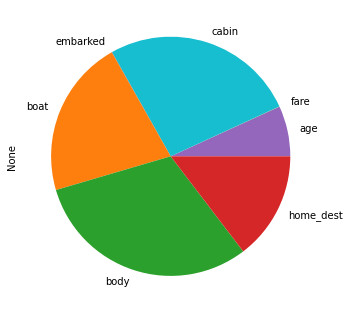

In [117]:
data.isnull().sum().plot.pie(figsize=(5.5,5.5))


###### Embarked and Fare have low number of missing data 

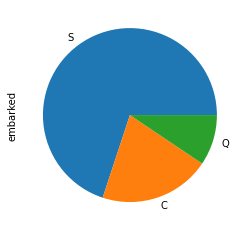

In [118]:
pd.value_counts(data['embarked'],sort=True).plot.pie()



###### Mostly Embarked from S( Southampton )

In [119]:
data.embarked=data.embarked.fillna('S')

###### Filling Missing Data with most Frequent value

In [120]:
data.fare.fillna(data.fare.median(),inplace=True)


######  Filling Fare missing value with Meadian

In [121]:
data.insert(0,'cabinchar',data.cabin.str[0])


###### Extract First Character from Name

In [122]:
titleList=[]
for i in range(0,1309):
    f=data.name.values[i].find('.')
    g=data.name.values[i].find(',')
    titleList.append(data.name.values[i][g+2:f])
    
data['titleList']=titleList



###### Extracted Titles from Name 


In [123]:
titleage =[]
for i in range(0,1309):
    if data.titleList[i] =='Master':
        titleage.append(1)
    elif data.titleList[i] =='Miss':
        titleage.append(2)
    else:
        titleage.append(3)

        
data['titleage']=titleage

###### Numerical weights to Selected Titles in order of Age

In [124]:
data['Mother']=np.where([data['titleList']=='Miss']and[data['parch']>2], 1, 0).reshape(1309,1)

###### New column 'Mother'  (They had higher chances of Survival)

In [125]:
data.head(2)

,cabinchar,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,titleList,titleage,Mother
0,B,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss,2,0
1,C,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master,1,0


In [126]:
data['family']=data.parch+data.sibsp
data.head(2)

,cabinchar,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,titleList,titleage,Mother,family
0,B,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss,2,0,0
1,C,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master,1,0,3


###### New column 'Family' 

In [127]:
data.drop(['boat','body','home_dest','ticket','name','cabin'],axis=1,inplace=True)
data.head(2)

,cabinchar,pclass,survived,sex,age,sibsp,parch,fare,embarked,titleList,titleage,Mother,family
0,B,1,True,female,29.0000,0,0,211.3375,S,Miss,2,0,0
1,C,1,True,male,0.9167,1,2,151.5500,S,Master,1,0,3


###### Dropping NonRelevent or Used columns

## Filling CabinChar and Age using KNN  

In [128]:
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

In [129]:
traincabin= data[data.cabinchar.notnull()]
testcabin = data[data.cabinchar.isnull()] 

In [130]:
clf=KNeighborsClassifier()
clf.fit(traincabin.drop(['cabinchar','age','embarked','titleList','sex'],axis=1),traincabin.cabinchar)
data.cabinchar[data.cabinchar.isnull()] = clf.predict(testcabin.drop(['cabinchar','age','embarked','titleList','sex'],axis=1))

<ipython-input-130-6c6c78f15607>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.cabinchar[data.cabinchar.isnull()] = clf.predict(testcabin.drop(['cabinchar','age','embarked','titleList','sex'],axis=1))


In [131]:
trainAge=data[data.age.notnull()]
testAge=data[data.age.isnull()]

In [132]:
clfAge=KNeighborsRegressor()
clfAge.fit(trainAge.drop(['cabinchar','age','embarked','titleList','sex'],axis=1),trainAge.age)
data.age[data.age.isnull()]=clfAge.predict(testAge.drop(['cabinchar','age','embarked','titleList','sex'],axis=1))

<ipython-input-132-acd556305862>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.age[data.age.isnull()]=clfAge.predict(testAge.drop(['cabinchar','age','embarked','titleList','sex'],axis=1))


###### Filled missing values with most probabalistic estimation using KNeighbors Algorithms

In [133]:
'NaN' in data.isnull()

False

###### Final Null Check

In [134]:
data=pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pclass                  1309 non-null   int64  
 1   survived                1309 non-null   bool   
 2   age                     1309 non-null   float64
 3   sibsp                   1309 non-null   int64  
 4   parch                   1309 non-null   int64  
 5   fare                    1309 non-null   float64
 6   titleage                1309 non-null   int64  
 7   Mother                  1309 non-null   int32  
 8   family                  1309 non-null   int64  
 9   cabinchar_A             1309 non-null   uint8  
 10  cabinchar_B             1309 non-null   uint8  
 11  cabinchar_C             1309 non-null   uint8  
 12  cabinchar_D             1309 non-null   uint8  
 13  cabinchar_E             1309 non-null   uint8  
 14  cabinchar_F             1309 non-null   

###### Dummy Encoding of Categorical Data 

In [135]:
target=data.survived

######  Prediction of Survival given as target

# Feature Extraction 

In [136]:
from sklearn.decomposition import PCA
data=pd.DataFrame(PCA(n_components=8,random_state=0).fit_transform(data.drop('survived',axis=1)))


###### PCA  for reducing large variance

In [137]:
data.head(2)

,0,1,2,3,4,5,6,7
0,177.780755,-9.766099,-2.826855,-0.636045,-0.079205,0.686435,-1.040244,-0.476214
1,116.746087,-35.058689,0.236209,0.331084,0.331235,-1.389845,-0.430874,-1.137526


In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score,auc,f1_score,r2_score
tnx,tsx,tny,tsy=train_test_split(data,target,test_size=0.3,random_state=0)

######  Spliting Training and Testing

# Training Models 

In [139]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


###### All necessary packages imported

### Decision Tree 

In [140]:
paramsdt = {'criterion':['gini','entropy'],'splitter':['random','best'],'max_depth':[8,9,10,11,12]}
griddt = GridSearchCV(DecisionTreeClassifier(random_state=0),param_grid=paramsdt,cv=5,scoring='f1_macro',n_jobs=4)
griddt.fit(tnx,tny)
griddt.best_params_

{'criterion': 'gini', 'max_depth': 9, 'splitter': 'random'}

In [141]:
clfdt=DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=20,random_state=0)
clfdt.fit(tnx,tny)
preddt=clfdt.predict(tsx)


In [142]:
print('Accuracy = ',format(accuracy_score(tsy,preddt),'.4f'))
print('F1 Score = ',format(f1_score(tsy,preddt),'.4f'))
print('Precision = ',format(precision_score(tsy,preddt),'.4f'))
print('Recall = ',format(recall_score(tsy,preddt),'.4f'))


Accuracy =  0.7430
F1 Score =  0.6406
Precision =  0.6716
Recall =  0.6122


###### Decesion Tree Cross Validation with Best parameters and Results 

###   Logistic Regression

In [143]:
clfknn=KNeighborsClassifier()
clfknn.fit(tnx,tny)
predknn=clfknn.predict(tsx)


In [144]:
print('Accuracy = ',format(accuracy_score(tsy,predknn),'.4f'))
print('F1 Score = ',format(f1_score(tsy,predknn),'.4f'))
print('Precision = ',format(precision_score(tsy,predknn),'.4f'))
print('Recall = ',format(recall_score(tsy,predknn),'.4f'))


Accuracy =  0.7023
F1 Score =  0.5895
Precision =  0.6087
Recall =  0.5714


###### Logistic Regression Cross Validation with Best parameters  and Results

 ### SVM 

In [145]:
paramssvm={'kernel':[ 'poly', 'rbf' ],'C':[4,5,6]}
gridsvm=GridSearchCV(SVC(random_state=0),param_grid=paramssvm,cv=5)
gridsvm.fit(tnx,tny)
gridsvm.best_params_


{'C': 6, 'kernel': 'rbf'}

In [146]:
clfsvm=SVC(C=6,kernel='rbf')
clfsvm.fit(tnx,tny)
predsvm=clfsvm.predict(tsx)


In [147]:
print('Accuracy = ',format(accuracy_score(tsy,predsvm),'.4f'))
print('F1 Score = ',format(f1_score(tsy,predsvm),'.4f'))
print('Precision = ',format(precision_score(tsy,predsvm),'.4f'))
print('Recall = ',format(recall_score(tsy,predsvm),'.4f'))


Accuracy =  0.7583
F1 Score =  0.6865
Precision =  0.6667
Recall =  0.7075


 ###### SVM Cross Validation with Best parameters  and Results 


#  Ensembling of All Three

### Voting Method and Results 

In [148]:
clfvot=VotingClassifier(estimators=[('dt',clfdt),('svm',clfsvm),('nb',clfknn)])
clfvot.fit(tnx,tny)
predvot=clfvot.predict(tsx)

In [149]:
print('Accuracy = ',format(accuracy_score(tsy,predvot),'.4f'))
print('F1 Score = ',format(f1_score(tsy,predvot),'.4f'))
print('Precision = ',format(precision_score(tsy,predvot),'.4f'))
print('Recall = ',format(recall_score(tsy,predvot),'.4f'))


Accuracy =  0.7710
F1 Score =  0.6939
Precision =  0.6939
Recall =  0.6939


# Confusion Matrix 

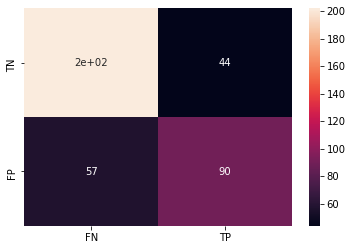

In [150]:
import seaborn as sns
sns.heatmap(confusion_matrix(tsy,preddt),annot=True,xticklabels=['FN','TP'],yticklabels=['TN','FP'])


######  CM for Decision Tree

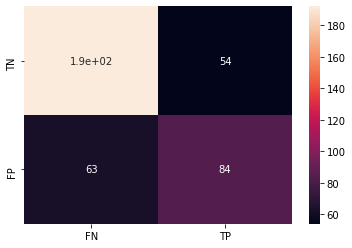

In [151]:
sns.heatmap(confusion_matrix(tsy,predknn),annot=True,xticklabels=['FN','TP'],yticklabels=['TN','FP'])

######  CM for KNN 

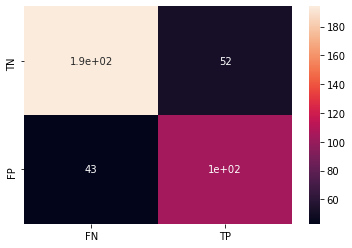

In [152]:
sns.heatmap(confusion_matrix(tsy,predsvm),annot=True,xticklabels=['FN','TP'],yticklabels=['TN','FP'])

######  CM for SVM

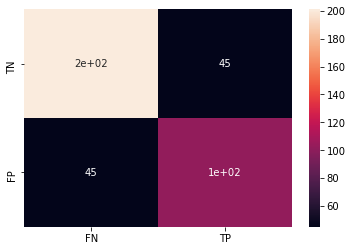

In [153]:
sns.heatmap(confusion_matrix(tsy,predvot),annot=True,xticklabels=['FN','TP'],yticklabels=['TN','FP'])

######  CM for Ensemble Learning

# ROC Curve

In [154]:
fpr,tpr,threshold=roc_curve(tsy,predvot)
roc_auc=auc(fpr,tpr)
fpr1,tpr1,threshold1=roc_curve(tsy,preddt)
roc_auc1=auc(fpr1,tpr1)
fpr2,tpr2,threshold2=roc_curve(tsy,predknn)
roc_auc2=auc(fpr2,tpr2)
fpr3,tpr3,threshold3=roc_curve(tsy,predsvm)
roc_auc3=auc(fpr3,tpr3)

###### Calculating Area Under ROC Curve 

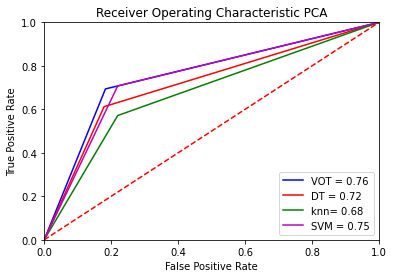

In [155]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic PCA')
plt.plot(fpr, tpr, 'b', label = 'VOT = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'r', label = 'DT = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'knn= %0.2f' % roc_auc2)
plt.plot(fpr2, tpr3, 'm', label = 'SVM = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Ensemble Learning gives best Predictions and Model among ALL. 